# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
import csv
import cv2
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

%matplotlib inline

In [2]:
# Load pickled data
import pickle

# TODO: fill this in based on where you saved the training and testing data
training_file = "../traffic-signs-data/train.p"
testing_file = "../traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [3]:
# Read in sign names
sign_names = []
with open('signnames.csv', 'r') as csvfile:
    signreader = csv.reader(csvfile)
    next(signreader)
    for row in signreader:
        sign_names.append(row[1])

In [4]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = len(X_train)

# TODO: number of testing examples
n_test = len(X_test)

# TODO: what's the shape of an image?
image_shape = X_train[0].shape

# TODO: how many classes are in the dataset
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Data Visualization

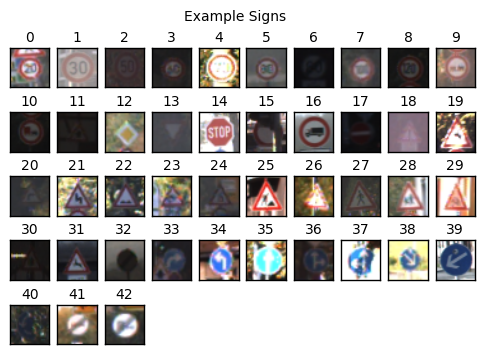

In [5]:
label_ids, label_indexes = np.unique(y_train, return_index=True)

fig = plt.figure()
fig.suptitle('Example Signs')
for label_id, label_index in zip(label_ids, label_indexes):
    sub = fig.add_subplot(5, 10, label_id + 1)
    sub.set_title(label_id, fontsize=10)
    sub.set_xticks([])
    sub.set_yticks([])
    sub.imshow(X_train[label_index])

The first visualization displays the first traffic sign in the training set for each of the labeled classes. As can be seen, the traffic signs tend to be centered in the image and occupy most of the image extent. It looks like the traffic signs are taken from real world situations, which results in images of various quality.

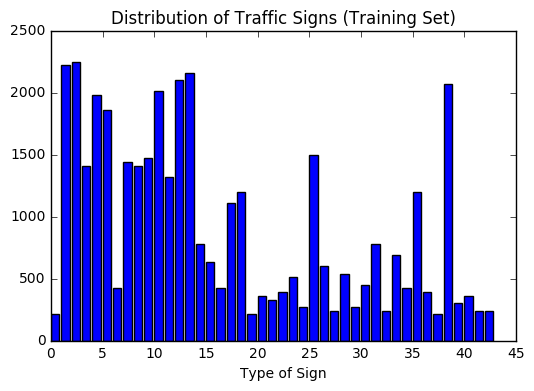

In [6]:
train_label_ids, train_label_counts = np.unique(y_train, return_counts=True)

plt.title('Distribution of Traffic Signs (Training Set)')
plt.xlabel('Type of Sign')
plt.bar(train_label_ids, train_label_counts)
plt.show()

The second visualization shows the distribution of the various classes of traffic signs in the training set. It is apparent that there are significant differences in the number of examples of each class. This imbalance in the training set could have a negative impact on training. The model may not have enough data from the smaller classes to generalize well, which could result in images being improperly classified as one of the larger classes.

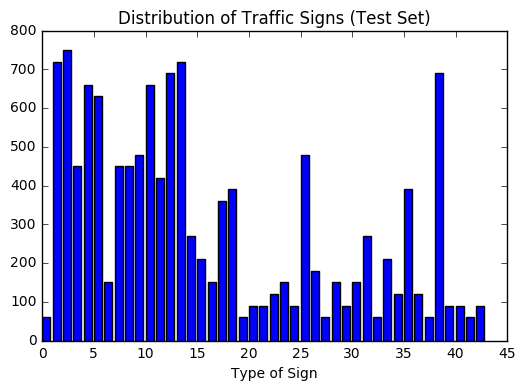

In [7]:
test_label_ids, test_label_counts = np.unique(y_test, return_counts=True)

plt.title('Distribution of Traffic Signs (Test Set)')
plt.xlabel('Type of Sign')
plt.bar(test_label_ids, test_label_counts)
plt.show()

The final visualization examines the distribution of traffic signs in the test set. These are the items that will be used to test how well the final model is likely to perform on unseen data. A quick visual comparison shows that the distribution in the test set closely matches the distribution in the training set.

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [8]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

encoder = LabelBinarizer()
encoder.fit(y_train)
y_train_encoded = encoder.transform(y_train).astype(np.float32)
y_test_encoded = encoder.transform(y_test).astype(np.float32)

In [9]:
def normalize_image(image):
    # First convert the image to grayscale.
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Then equalize the grayscale image to improve the contrast in the image.
    equalized_image = cv2.equalizeHist(grayscale_image)
    
    # Finally, normalize the the color values to a range of 0.0 to 1.0.
    normalized_image = equalized_image / 255.

    # Return the processed image.
    return normalized_image
    
X_train_normalized = np.array([normalize_image(x) for x in X_train])
X_test_normalized = np.array([normalize_image(x) for x in X_test])

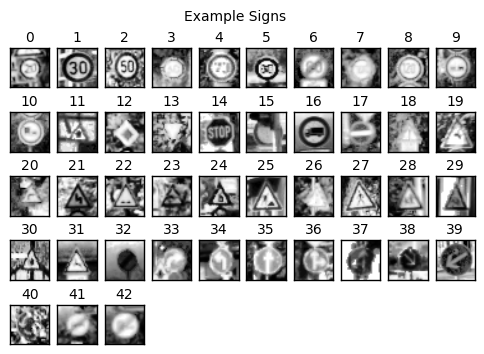

In [10]:
label_ids, label_indexes = np.unique(y_train, return_index=True)

fig = plt.figure()
fig.suptitle('Example Signs')
for label_id, label_index in zip(label_ids, label_indexes):
    sub = fig.add_subplot(5, 10, label_id + 1)
    sub.set_title(label_id, fontsize=10)
    sub.set_xticks([])
    sub.set_yticks([])
    sub.imshow(X_train_normalized[label_index], cmap='gray')

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

There were two major steps taken to preprocess the data: encode the labels and normalize the images.

The traffic sign labels were stored as numbers in a range between 0 and 42. However, treating the labels as numeric values doesn't make sense. They are actually better described as discrete categories with no inherent ordering between them. A label binarizer encoder was used to transform each label into a one-hot vector encoding.

Then each image was normalized to make them easier to work with. This normalization process involved three steps. First, the image was converted to grayscale to remove the influence of color and reduce the corresponding dimensionality of the input. Second, each image was equalized to improve the contrast. Finally, a minmax scaler was applied to scale the pixel values to a range of 0.0 to 1.0.

Converting the images to grayscale is a potentially controversial step. Traffic signs are designed to make use of specific colors to draw drivers' atttention. Removing this signal could make it more difficult to differentiate between different kinds of signs. However, the reduced complexity of the images will also make it easier to learn other indicators like shapes or symbols.

The magic sauce of the preprocessing is the histogram equalization of the images. As shown in the visualizations, the transformed images are sharper and easier to recognize than the original images.

Finally, while the rescaling of the values of the pixels doesn't have an explicit impact on the correctness of the data, smaller parameter values are more robust to numerical approximation algorithms and should make it easier to converge the model.

In [11]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cellbs as needed.

X_train_split, X_validation_split, y_train_split, y_validation_split = train_test_split(
    X_train_normalized, y_train_encoded, test_size=0.2, random_state=1, stratify=y_train_encoded)

print("Number of training examples =", len(X_train_split))
print("Number of validation examples =", len(X_validation_split))

Number of training examples = 31367
Number of validation examples = 7842


### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

The project was provided with separate training and testing sets. The test set will be set aside and left unused until it is time to evaluate the performance of the final model.

The training set was then split into a smaller training set as well as a validation set. The validation set will be used to evaluate and tune the model's architecture and hyper parameters to select the best model.

The function used to split the validation set from the original training set uses a stratified shuffle which ensures that the proportion of each class remains roughly the same in each set.

For now, no additional data was generated, but data augmentation is a valuable strategy to improve the training of machine learning models. Some techniques to consider if additional data were desired is to slightly perturb the original images by generating new images that are slightly translated or rotated or that have small amounts of random noise applied. These new images would help combat overfitting.

In [26]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

# Create a weight variable of the given shape.
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)
    
# Create a bias variable of the given shape.
def bias_variable(shape):
    initial = tf.zeros(shape=shape)
    return tf.Variable(initial)
 
# Weights for each layer of the network.
weights = {
    'conv1': weight_variable([5, 5, 1, 32]),
    'conv2': weight_variable([5, 5, 32, 128]),
    'fc1': weight_variable([8*8*128, 1024]),
    'out': weight_variable([1024, n_classes])
}

# Biases for each layer of the network.
biases = {
    'conv1': bias_variable([32]),
    'conv2': bias_variable([128]),
    'fc1': bias_variable([1024]),
    'out': bias_variable([n_classes])
}

In [27]:
# Concatenate a convolution layer with ReLU activation.
def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

# Concatenate a max pool layer for dimensionality reduction.
def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1,k,k,1], strides=[1,k,k,1], padding='SAME')

def conv_network(x, weights, biases, keep_prob):
    # Reshape input to 4D tensor.
    x = tf.reshape(x, [-1, 32, 32, 1])
    
    # 5x5 convolution with ReLU activation and max pooling.
    # Dimension: 32x32x1 to 16x16x32
    conv1 = conv2d(x, weights['conv1'], biases['conv1'])
    conv1 = maxpool2d(conv1)
    
    # 5x5 convolution with ReLU activation and max pooling.
    # Dimension: 16x16.32 to 8x8x64
    conv2 = conv2d(conv1, weights['conv2'], biases['conv2'])
    conv2 = maxpool2d(conv2)
    
    # Flatten the convolution layer before the fully connected layer.
    conv2 = tf.reshape(conv2, [-1, 8*8*128])
    
    # Fully connected with ReLU activation and dropout.
    # Dimension: 8x8x64 to 1024.
    fc1 = tf.add(tf.matmul(conv2, weights['fc1']), biases['fc1'])
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, keep_prob)
    
    # Logit redout
    # Dimension: 1024 to n_classes.)
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

In [28]:
# Probability to keep units in the dropout layer.
keep_prob = tf.placeholder(tf.float32)

# Input and output placeholders.
x = tf.placeholder(tf.float32, [None, 32, 32])
y = tf.placeholder(tf.float32, [None, n_classes])

# Feed dicts for validation and test accuracy checks.
valid_feed_dict = {x: X_validation_split, y: y_validation_split, keep_prob: 1.0}
test_feed_dict = {x: X_test_normalized, y: y_test_encoded, keep_prob: 1.0}

# Build model
logits = conv_network(x, weights, biases, keep_prob)

prediction = tf.nn.softmax(logits)

cross_entropy = -tf.reduce_sum(y * tf.log(prediction), reduction_indices=1)

loss = tf.reduce_mean(cross_entropy)

# Determine if the predictions are correct
is_correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))

# Calculate the accuracy of the predictions.
accuracy = tf.reduce_mean(tf.cast(is_correct_prediction, tf.float32))

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

To take advantage of the two dimensional structure of the data set, a convolutional network was the obvious choice.

The network starts with a 5x5 convolution layer with a depth of 32. The kernel size was chosen to be large enough to detect interesting features within the images but small enough to constrain the number of parameters that would need to be learned. A ReLU activation function provides some nonlinearity to the model. Finally a 2x2 max pool layer is used to reduce the dimensionality for the next layer in the model.

A second 5x5 convolution layer was then used to detect higher level features within the data. Because of the reduced dimensionality as a result of the previous pooling layer, the depth of the filter was increased to 64. Once again, a ReLU activation function was used to introduce nonlinearity. And, as before, a 2x2 max pool layer is used to further reduce the dimensionality of the model.

The results of the convolution layers are then collected into a fully connected layer with a width of 1024. Once again a ReLU activation layer provides nonlinearity to the model. Finally, a dropout layer is used to help prevent overfitting in the model.

The final redout layer reduces the dimension to 43, one for each class in the data set. These values are then processed by a softmax layer to distribute the weights so that the sum up to 1.0.

In [29]:
### Train your model here.
### Feel free to use as many code cells as needed.

epochs = 12
batch_size = 50
learning_rate = 0.0001
dropout = 0.75

optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)  

session = tf.Session()
session.run(tf.initialize_all_variables())

batch_count = int(math.ceil(len(X_train_split)/batch_size))
for epoch in range(epochs):
    for batch in range(batch_count):
        batch_start = batch * batch_size
        x_batch = X_train_split[batch_start:batch_start + batch_size]
        y_batch = y_train_split[batch_start:batch_start + batch_size]
        _, l = session.run([optimizer, loss], feed_dict={x: x_batch, y: y_batch, keep_prob: dropout})
        
    valid_accuracy = session.run(accuracy, feed_dict=valid_feed_dict)
    print("Epoch: {}, Validation accuracy: {}".format(epoch, valid_accuracy))

test_accuracy = session.run(accuracy, feed_dict=test_feed_dict)
print("Test accuracy: {}".format(test_accuracy))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Epoch: 0, Validation accuracy: 0.7563124299049377
Epoch: 1, Validation accuracy: 0.8834483623504639
Epoch: 2, Validation accuracy: 0.932160496711731
Epoch: 3, Validation accuracy: 0.9502682089805603
Epoch: 4, Validation accuracy: 0.9688857793807983
Epoch: 5, Validation accuracy: 0.9757717847824097
Epoch: 6, Validation accuracy: 0.9835504293441772
Epoch: 7, Validation accuracy: 0.9835504293441772
Epoch: 8, Validation accuracy: 0.9839330315589905
Epoch: 9, Validation accuracy: 0.9857182502746582
Epoch: 10, Validation accuracy: 0.9882686138153076
Epoch: 11, Validation accuracy: 0.98890620470047
Test accuracy: 0.8773559927940369


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

The model was trained by trial and error to discover reasonable values for the various hyperparameters. A more rigorous experiment, however, could further refine these values through the use of a grid search.

The ADAM optimizer was used after a few trial runs showed it to be significantly faster than the standard gradient descent optimizer. The standard ADAM learning rate of 0.0001 worked well.

The dropout rate of 0.75 was chosen to apply some regularization to the model without introducing too much bias.

A batch size of 50 seemed conservative and 10 epochs was enough for the model to converge to a reasonable accuracy. In fact, the accuracy began to degrade after progressing beyond this.

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

As mentioned previously, a convolution network seemed like the most appropriate model to learn the traffic signs data set. While a deep network would most likely have produced better results, I wanted to start with a simpler model to get a better intuition for how convolution networks would perform. I decided to try a network with two convolution layers. The idea would be to allow enough flexibility for the first layer to detect simple features in the images, which the second convolution layer would be able to expand upon to detect more complex features.

Tuning the model consisted mostly of trial and error, experimenting with various combinations of options to determine which ones would have the most impact on training. For example, the choice of optimizer and the learning rate used had a significant impact on how fast the model could be trained. Other options like batch size, while important, did not have as much of an effect.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

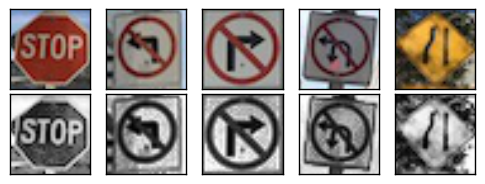

In [35]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

image_files = [
    'traffic-signs/stop.jpg',
    'traffic-signs/no-left.jpg',
    'traffic-signs/no-right.jpg',
    'traffic-signs/no-right-or-uturn.jpg',
    'traffic-signs/merge.jpg'
]

image_names = [
    'Stop Sign',
    'No Left Turn',
    'No Right Turn',
    'No Left Turn or U-Turn',
    'Merge Lanes'
]

X_new = []
X_new_normalized = []
fig = plt.figure()
for index, filename in enumerate(image_files):
    image = mpimg.imread(filename)
    normalized_image = normalize_image(image)

    X_new.append(image)
    X_new_normalized.append(normalized_image)

    sub = fig.add_subplot(1, 5, index + 1)
    sub.set_xticks([])
    sub.set_yticks([])
    sub.imshow(image)
    
    sub = fig.add_subplot(2, 5, 5 + index + 1)
    sub.set_xticks([])
    sub.set_yticks([])
    sub.imshow(normalized_image, cmap='gray')

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

In [39]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

y_new = session.run(prediction, feed_dict={x: X_new_normalized, keep_prob: 1.0})

New Signs vs. Predicted Signs


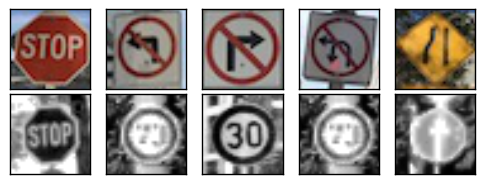

In [61]:
fig = plt.figure()

for index, image in enumerate(X_new):
    sub = fig.add_subplot(1, 5, index + 1)
    sub.set_xticks([])
    sub.set_yticks([])
    sub.imshow(image)
    
for index, label_id in enumerate(y_new):
    sub = fig.add_subplot(2, 5, 5 + index + 1)
    sub.set_xticks([])
    sub.set_yticks([])
    sub.imshow(X_train_normalized[label_indexes[np.argmax(label_id)]], cmap='gray')
    
print('New Signs vs. Predicted Signs')

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset?_


**Answer:**

Unfortunately, the model was not able to perform as well with the new images as it did with the test data set. The final accuracy of the model on the test set was 87.7%. If that rate generalized to the new images, we would expect four of the five to be predicted correctly. However, the model was only able to identify one of the five images.

This was not an entirely unexpected result. The new images were taken from traffic signs found in downtown San Francisco. Traffic signs in the United States can be very different than the German counterparts that were used to train the model. In a sense, the model "overfit" to the the German signs and failed to generalize to the concept of traffic signs. By comparison, a German tourist visiting the United States for the first time would still be likely to recognize signs they had never seen before and still be able to drive safely.

Even if the new signs perfectly matched the ones used to train the model, we would still expect some differences in performance. The quality of the camera that took the photos, the angle and position of the signs in the image, how the image was crapped, lighting conditions, and other factors could all lead to different performance.

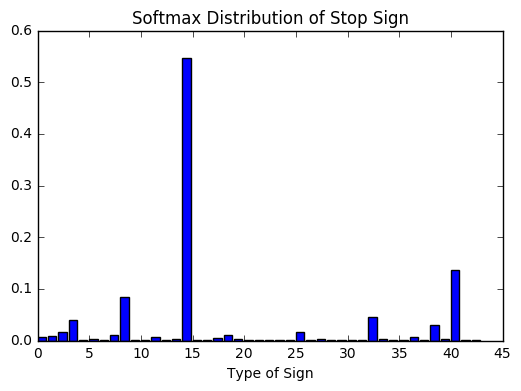

In [95]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

plt.title('Softmax Distribution of Stop Sign')
plt.xlabel('Type of Sign')
plt.bar(range(43), y_new[0])
plt.show()

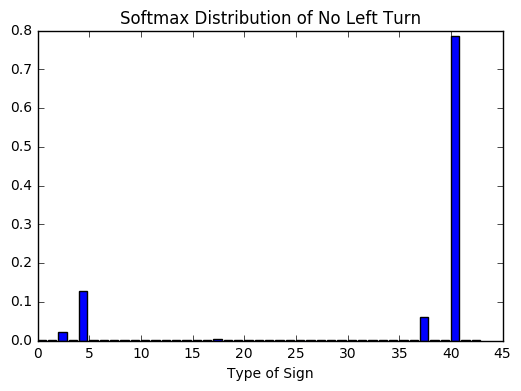

In [96]:
plt.title('Softmax Distribution of No Left Turn')
plt.xlabel('Type of Sign')
plt.bar(range(43), y_new[1])
plt.show()

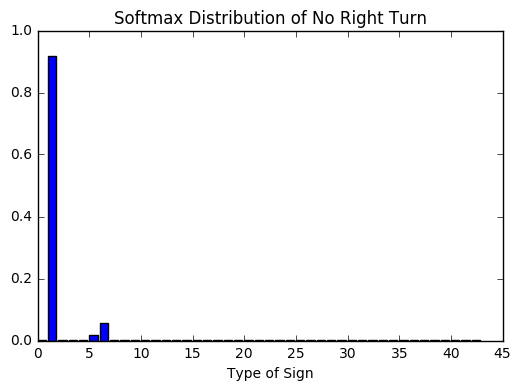

In [98]:
plt.title('Softmax Distribution of No Right Turn')
plt.xlabel('Type of Sign')
plt.bar(range(43), y_new[2])
plt.show()

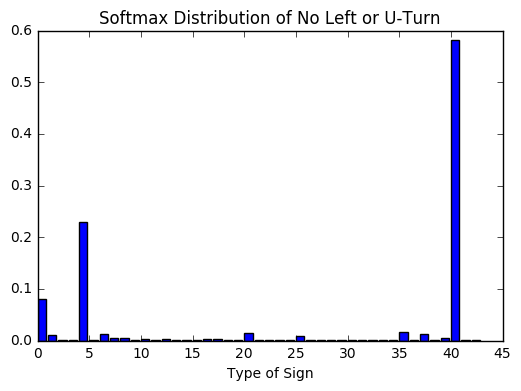

In [141]:
plt.title('Softmax Distribution of No Left or U-Turn')
plt.xlabel('Type of Sign')
plt.bar(range(43), y_new[3])
plt.show()

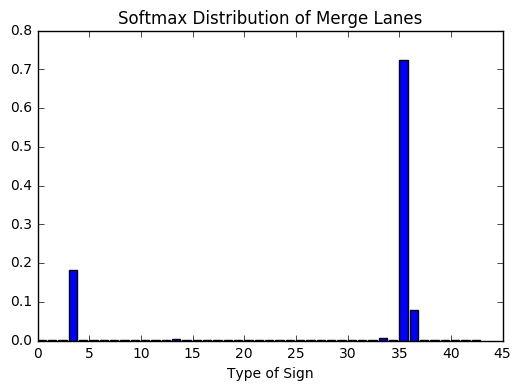

In [101]:
plt.title('Softmax Distribution of Merge Lanes')
plt.xlabel('Type of Sign')
plt.bar(range(43), y_new[4])
plt.show()

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

As shown by the softmax distribution above, the model seemed very certain of it's predictions, even if the signs were not part of the training set. In fact, probably most surprisingly, the model was least sure of the stop sign, but this is the only one of the new signs that appears in the training set!

The certainty with which the model predicted signs that turned out to be misclassified is a bit alarming. There could be severe safety consequences if a car chose to act on what it believed the sign to be rather than what it was.

In [142]:
weight, cls = session.run(tf.nn.top_k(prediction, k=5, sorted=True), feed_dict={x: X_new_normalized, keep_prob: 1.0})
for i, (ws, cs) in enumerate(zip(weight, cls)):
    print("Top Predictions for {}".format(image_names[i]))
    for (w, c) in zip(ws, cs):
        print("{:.2}: {}".format(w, sign_names[c]))
    print()

Top Predictions for Stop Sign
0.55: Stop
0.14: Roundabout mandatory
0.084: Speed limit (120km/h)
0.046: End of all speed and passing limits
0.039: Speed limit (60km/h)

Top Predictions for No Left Turn
0.78: Roundabout mandatory
0.13: Speed limit (70km/h)
0.06: Go straight or left
0.021: Speed limit (50km/h)
0.0049: No entry

Top Predictions for No Right Turn
0.92: Speed limit (30km/h)
0.057: End of speed limit (80km/h)
0.018: Speed limit (80km/h)
0.0031: Go straight or right
0.0012: Turn right ahead

Top Predictions for No Left Turn or U-Turn
0.58: Roundabout mandatory
0.23: Speed limit (70km/h)
0.081: Speed limit (20km/h)
0.017: Ahead only
0.015: Dangerous curve to the right

Top Predictions for Merge Lanes
0.72: Ahead only
0.18: Speed limit (60km/h)
0.079: Go straight or right
0.0062: Turn right ahead
0.004: Yield



It's interesting to imagine how the model might have made it's predictions when confronted with a sign it wasn't trained on. For example, the circles around the no turn signs could easily be misinterpreted as the circular speed limit signs. In fact, the left turn sign kind of looks like the start of a seven (70km/h) while the right turn sign looks a little like the start of a three (30km/h).

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

The newly acquired images were taken with a camera phone while walking through downtown San Francisco. They were then transferred to a desktop workstation for resizing. The images were first cropped to a sqare aspect ration with the traffic sign in the center and spanning most of the resized image. The images were then resized to 32x32 RGB JPEGs to match the size and style of the training data. No additional image manipulation or retouching was applied. The images were then imported into this project where they had the same image preprocessing applied to them as the rest of the training and test images.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.